In [1]:
import numpy as np
import sys; sys.path.insert(0, "../"); from utils import *
from parametric_discovery_pinn import ParametricPINN
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR
from parametric_pde_diff import TrainSGTRidge

In [2]:
data = pickle_load("../parametric_pde_data/parametric_burgers.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]

Exact = data['u']
X, T = np.meshgrid(x, t)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 20000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

u_xx_true = 0.1*np.ones(time_dims)
uu_x_true = -1*(1+0.25*np.sin(t))

Loaded from ../parametric_pde_data/parametric_burgers.pkl


In [3]:
pinn = ParametricPINN(scale=False, lb=lb, ub=ub)

In [4]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    losses = pinn.loss(*dimension_slicing(X_train), u_train)
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return sum(losses)
    else: return losses

In [5]:
def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    loss = sum(pinn.loss(*dimension_slicing(X_train), u_train))
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

In [6]:
# ใส่เพิ่มทีหลังได้
# optimizer = MADGRAD(pinn.parameters(), lr=1e-3, momentum=0.9)
# for i in range(150):
#     pinn.train()
#     optimizer.step(pcgrad_closure)
#     if i%10==0:
#         loss = pcgrad_closure(return_list=True)
#         print(loss)
        
f_opt = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=300, history_size=300)
for i in range(50):
    f_opt.step(finetuning_closure)
    if i%10==0:
        loss = finetuning_closure()
        print(loss.item())
        
# −0.56759363*np.sin(x0)−0.8300467 will be detected.

6.464694160968065e-05
2.566914872659254e-06
2.5650622319517424e-06
2.564962414908223e-06
2.564962414908223e-06


In [7]:
sum(pinn.loss(*dimension_slicing(X_star), u_star))

tensor(2.5907e-06, grad_fn=<AddBackward0>)

In [14]:
u_preds, learned_func = pinn(*dimension_slicing(X_star))
learned_func1 = learned_func[:, 0:1].reshape(X.shape).mean(axis=1).detach().numpy()
learned_func2 = learned_func[:, 1:2].reshape(X.shape).mean(axis=1).detach().numpy()

In [15]:
print(np.mean((learned_func1-uu_x_true)**2))
print(np.mean((learned_func2-u_xx_true)**2))

0.016162229544351373
5.448478063125935e-06


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

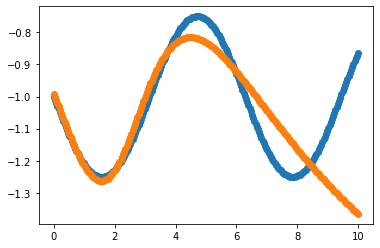

In [17]:
plt.scatter(t, uu_x_true)
plt.scatter(t, learned_func1)
plt.show()

In [18]:
from pysr import pysr, best

In [19]:
equations = pysr(
    t, learned_func1,
    populations=50, npop=1000, niterations=5,
    binary_operators=["+", "*"],
    unary_operators=["sin", "cos"],
)

Running on julia -O3 /var/folders/z3/_stfms3523dd5mnfr3ch5n100000gp/T/tmpu3c7ilm5/runfile.jl
Activating environment on workers.
      From worker 5:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 3:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 4:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
      From worker 2:	  Activating environment at `/usr/local/lib/python3.9/site-packages/Project.toml`
Importing installed module on workers...Finished!
Testing module on workers...Finished!
Testing entire pipeline on workers...Finished!
Started!

Cycles per second: 4.970e+02
Head worker occupation: 3.2%
Progress: 1 / 250 total iterations (0.400%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           2.762e-02  -0.000e+00  -1.0710331
5           2.643e-02  1.106e-02  (-1.0113897 + (-0.011928808 * x0))


In [21]:
best(equations)

-0.17971173*sin(x0) - 1.0383017

In [ ]:
# xx = (to_tensor(t, False)/10.0).reshape(-1, 1)
# yy = pinn.parametric_func_net(xx)[:, 0:1].detach().numpy()

# equations = pysr(
#     xx.detach().numpy(), yy,
#     populations=50, niterations=5,
#     binary_operators=["+", "*"],
#     unary_operators=["sin", "cos"]
# )

In [ ]:
# To discover using TrainSGTRidge

# Compute Theta -> Candi features and estimated u_t
# Create the groups
# Train TrainSGTRidge
# Look for np.linalg.norm(xi[j,:]) > 10**-10
# Apply PySR on the results